In [1]:
! wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

import shutil
shutil.unpack_archive("bank+marketing.zip", ".")
shutil.unpack_archive("bank.zip", ".")

--2024-10-07 18:11:52--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip.1’

bank+marketing.zip.     [  <=>               ] 999.85K  2.63MB/s    in 0.4s    

2024-10-07 18:11:53 (2.63 MB/s) - ‘bank+marketing.zip.1’ saved [1023843]



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
features = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]
df = df[features]
df.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


# Q1
What is the most frequent observation (mode) for the column education?

In [5]:
df.education.mode()

,education
0,secondary


# Q2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

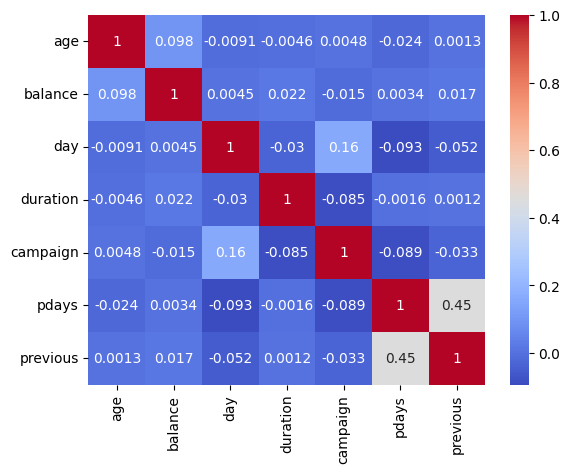

In [6]:
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.show()

## Target encoding

    Now we want to encode the y variable.
    Let's replace the values yes/no with 1/0.

In [7]:
y = df.y.map({"yes": 1, "no": 0})
df = df.drop("y", axis=1)
y.value_counts()

,count
y,
0,39922
1,5289


## Split the data

    Split your data in train/val/test sets with 60%/20%/20% distribution.
    Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
    Make sure that the target value y is not in your dataframe.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# Q3
Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.

In [9]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding for categorical variables
encoder = OrdinalEncoder()
categorical_columns = X_train.select_dtypes(include=['object']).columns

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
mi_scores = mutual_info_classif(X_train_encoded, y_train, discrete_features=True)
mi_scores = mi_scores.round(2)
mi_scores = pd.Series(mi_scores, index=categorical_columns)
mi_scores.sort_values(ascending=False)

,0
month,0.03
poutcome,0.03
job,0.01
housing,0.01
contact,0.01
marital,0.00
education,0.00


# Q4

    Now let's train a logistic regression.
    Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
    Fit the model on the training dataset.
        To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    Calculate the accuracy on the validation dataset and round it to 2 decimal digits.


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



def encode_and_evaluate(model, X_train, X_val, y_train, y_val):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')
    categorical_columns = X_train.select_dtypes(include=['object']).columns
    numerical_columns = X_train.select_dtypes(exclude=['object']).columns
    X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
    X_val_encoded = encoder.transform(X_val[categorical_columns])

    X_train = np.hstack((X_train_encoded, X_train[numerical_columns].values))
    X_val = np.hstack((X_val_encoded, X_val[numerical_columns].values))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

accuracy = encode_and_evaluate(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42),
                               X_train, X_val, y_train, y_val)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


# Q5

    Let's find the least useful feature using the feature elimination technique.
    Train a model with all these features (using the same parameters as in Q4).
    Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
    For each feature, calculate the difference between the original accuracy and the accuracy without the feature.


In [11]:
base_accuracy = encode_and_evaluate(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42),
                               X_train, X_val, y_train, y_val)
features, acc_per_feat, acc_diff_per_feat = [], [], []
for feat in X_train.columns:
    acc = encode_and_evaluate(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42),
                              X_train.drop(feat, axis=1), X_val.drop(feat, axis=1), y_train, y_val)
    features.append(feat)
    acc_per_feat.append(acc)
    acc_diff_per_feat.append(base_accuracy - acc)

pd.DataFrame({"feature": features, "accuracy": acc_per_feat, "accuracy_diff": acc_diff_per_feat}).sort_values(by="accuracy_diff")

,feature,accuracy,accuracy_diff
7,day,0.901349,-0.000442
11,pdays,0.901239,-0.000332
12,previous,0.901128,-0.000221
2,marital,0.901017,-0.000111
3,education,0.901017,-0.000111
0,age,0.900907,0.000000
1,job,0.900907,0.000000
4,balance,0.900796,0.000111
10,campaign,0.900686,0.000221
6,contact,0.900464,0.000442


# Q6

    Now let's train a regularized logistic regression.
    Let's try the following values of the parameter C: [0, 0.01, 0.1, 1, 10].
    Train models using all the features as in Q4.
    Calculate the accuracy on the validation dataset and round it to 3 decimal digits.


In [12]:
param_list = [0.01, 0.1, 1, 10, 100] # fixed - C must be positive and 100 is in the multiple choice list
acc_per_param = [encode_and_evaluate(
    LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42),
    X_train, X_val, y_train, y_val) for C in param_list]
acc_per_param = np.round(acc_per_param, 3)
pd.DataFrame({"C": param_list, "accuracy": acc_per_param}).sort_values(by="accuracy")

,C,accuracy
0,0.01,0.898
1,0.10,0.901
2,1.00,0.901
3,10.00,0.901
4,100.00,0.901
